### Assignment3
#### 50380788 Mukesh Ravichandran

#### Data files for this work are 
* **Google.csv**, the Google Products dataset
* **Amazon.csv**, the Amazon dataset
* **Google_small.csv**, 200 records sampled from the Google data
* **Amazon_small.csv**, 200 records sampled from the Amazon data
* **Amazon_Google_perfectMapping.csv**, the "gold standard" mapping
* **stopwords.txt**, a list of common English words



In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

import pyspark
from pyspark import SparkContext, SparkConf

# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=e46420919207064dfc4a280e311b0ad86bdefad417f4ddf6c597c69a1265067c
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 18 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected packag

In [ ]:
# Just run this code
!pip install wget
import wget

GOOGLE_PATH = 'Google.csv'
GOOGLE_SMALL_PATH = 'Google_small.csv'
AMAZON_PATH = 'Amazon.csv'
AMAZON_SMALL_PATH = 'Amazon_small.csv'
GOLD_STANDARD_PATH = 'Amazon_Google_perfectMapping.csv'
STOPWORDS_PATH = 'stopwords.txt'

url = 'https://phantom.cs.qc.cuny.edu/li/bda/'
wget.download(url + GOOGLE_PATH, GOOGLE_PATH)
wget.download(url + GOOGLE_SMALL_PATH, GOOGLE_SMALL_PATH)
wget.download(url + AMAZON_PATH, AMAZON_PATH)
wget.download(url + AMAZON_SMALL_PATH, AMAZON_SMALL_PATH)
wget.download(url + GOLD_STANDARD_PATH, GOLD_STANDARD_PATH)
wget.download(url + STOPWORDS_PATH, STOPWORDS_PATH)

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=f4c15b78c7144580fadaac8a748d5278cd06bc28053fd6c6148ae79e8a758c00
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


'stopwords.txt'

In [ ]:
import hashlib

class TestFailure(Exception):
  pass
class PrivateTestFailure(Exception):
  pass

class Test(object):
  passed = 0
  numTests = 0
  failFast = False
  private = False

  @classmethod
  def setFailFast(cls):
    cls.failFast = True

  @classmethod
  def setPrivateMode(cls):
    cls.private = True

  @classmethod
  def assertTrue(cls, result, msg=""):
    cls.numTests += 1
    if result == True:
      cls.passed += 1
      print("1 test passed.")
    else:
      print("1 test failed. " + msg)
      if cls.failFast:
        if cls.private:
          raise PrivateTestFailure(msg)
        else:
          raise TestFailure(msg)

  @classmethod
  def assertEquals(cls, var, val, msg=""):
    cls.assertTrue(var == val, msg)

  @classmethod
  def assertEqualsHashed(cls, var, hashed_val, msg=""):
    cls.assertEquals(cls._hash(var), hashed_val, msg)

  @classmethod
  def printStats(cls):
    print("{0} / {1} test(s) passed.".format(cls.passed, cls.numTests))

  @classmethod
  def _hash(cls, x):
    return hashlib.sha1(str(x)).hexdigest()

### **Part 0: Preliminaries**


In [ ]:
import re
DATAFILE_PATTERN = '^(.+),"(.+)",(.*),(.*),(.*)'

def removeQuotes(s):
    """ Remove quotation marks from an input string
    Args:
        s (str): input string that might have the quote "" characters
    Returns:
        str: a string without the quote characters
    """
    return ''.join(i for i in s if i!='"')


def parseDatafileLine(datafileLine):
    """ Parse a line of the data file using the specified regular expression pattern
    Args:
        datafileLine (str): input string that is a line from the data file
    Returns:
        str: a string parsed using the given regular expression and without the quote characters
    """
    match = re.search(DATAFILE_PATTERN, datafileLine.decode('UTF-8'))
    if match is None:
        print('Invalid datafile line: %s' % datafileLine)
        return (datafileLine, -1)
    elif match.group(1) == '"id"':
        print('Header datafile line: %s' % datafileLine)
        return (datafileLine, 0)
    else:
        product = '%s %s %s' % (match.group(2), match.group(3), match.group(4))
        return ((removeQuotes(match.group(1)), product), 1)

In [ ]:
import sys
import os


def parseData(filename):
    """ Parse a data file
    Args:
        filename (str): input file name of the data file
    Returns:
        RDD: a RDD of parsed lines
    """
    return (sc
            .textFile(filename, 4, 0)
            .map(parseDatafileLine)
            .cache())

def loadData(filename):
    """ Load a data file
    Args:
        filename (str): input file name of the data file
    Returns:
        RDD: a RDD of parsed valid lines
    """
    raw = parseData(filename).cache()
    failed = (raw
              .filter(lambda s: s[1] == -1)
              .map(lambda s: s[0]))
    for line in failed.take(10):
        print('%s - Invalid datafile line: %s' % (path, line))
    valid = (raw
             .filter(lambda s: s[1] == 1)
             .map(lambda s: s[0])
             .cache())
    print('%s - Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (filename,
                                                                                        raw.count(),
                                                                                        valid.count(),
                                                                                        failed.count()))
    assert failed.count() == 0
    assert raw.count() == (valid.count() + 1)
    return valid

googleSmall = loadData(GOOGLE_SMALL_PATH)
google = loadData(GOOGLE_PATH)
amazonSmall = loadData(AMAZON_SMALL_PATH)
amazon = loadData(AMAZON_PATH)

Google_small.csv - Read 201 lines, successfully parsed 200 lines, failed to parse 0 lines
Google.csv - Read 3227 lines, successfully parsed 3226 lines, failed to parse 0 lines
Amazon_small.csv - Read 201 lines, successfully parsed 200 lines, failed to parse 0 lines
Amazon.csv - Read 1364 lines, successfully parsed 1363 lines, failed to parse 0 lines


#### Let's examine the lines that were just loaded in the two subset (small) files - one from Google and one from Amazon

In [ ]:
for line in googleSmall.take(3):
    print('google: %s: %s\n' % (line[0], line[1]))

for line in amazonSmall.take(3):
    print('amazon: %s: %s\n' % (line[0], line[1]))

google: http://www.google.com/base/feeds/snippets/11448761432933644608: spanish vocabulary builder "expand your vocabulary! contains fun lessons that both teach and entertain you'll quickly find yourself mastering new terms. includes games and more!" 

google: http://www.google.com/base/feeds/snippets/8175198959985911471: topics presents: museums of world "5 cd-rom set. step behind the velvet rope to examine some of the most treasured collections of antiquities art and inventions. includes the following the louvre - virtual visit 25 rooms in full screen interactive video detailed map of the louvre ..." 

google: http://www.google.com/base/feeds/snippets/18445827127704822533: sierrahome hse hallmark card studio special edition win 98 me 2000 xp "hallmark card studio special edition (win 98 me 2000 xp)" "sierrahome"

amazon: b000jz4hqo: clickart 950 000 - premier image pack (dvd-rom)  "broderbund"

amazon: b0006zf55o: ca international - arcserve lap/desktop oem 30pk "oem arcserve backup 

### **Part 1: ER as Text Similarity - Bags of Words**


### **1(a) Tokenize a String**


In [ ]:
# TODO: Replace <FILL IN> with appropriate code
quickbrownfox = 'A quick brown fox jumps over the lazy dog.'
split_regex = r'\W+'

def simpleTokenize(string):
    """ A simple implementation of input string tokenization
    Args:
        string (str): input string
    Returns:
        list: a list of tokens
    """
    return [token for token in re.split(split_regex, string.lower()) if token != ""]

print(simpleTokenize(quickbrownfox)) # Should give ['a', 'quick', 'brown', ... ]

['a', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


In [ ]:
# TEST Tokenize a String (1a)
Test.assertEquals(simpleTokenize(quickbrownfox),
                  ['a','quick','brown','fox','jumps','over','the','lazy','dog'],
                  'simpleTokenize should handle sample text')
Test.assertEquals(simpleTokenize(' '), [], 'simpleTokenize should handle empty string')
Test.assertEquals(simpleTokenize('!!!!123A/456_B/789C.123A'), ['123a','456_b','789c','123a'],
                  'simpleTokenize should handle puntuations and lowercase result')
Test.assertEquals(simpleTokenize('fox fox'), ['fox', 'fox'],
                  'simpleTokenize should not remove duplicates')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


### **(1b) Removing stopwords**


In [ ]:
# TODO: Replace <FILL IN> with appropriate code
stopfile = STOPWORDS_PATH
stopwords = set(sc.textFile(stopfile).collect())
print('These are the stopwords: %s' % stopwords)

def tokenize(string):
    """ An implementation of input string tokenization that excludes stopwords
    Args:
        string (str): input string
    Returns:
        list: a list of tokens without stopwords
    """
    return [word for word in simpleTokenize(string) if not word in stopwords]

print(tokenize(quickbrownfox)) # Should give ['quick', 'brown', ... ]

These are the stopwords: {'being', 'doing', 'her', 'he', 'over', 'nor', 'they', 'any', 'off', 'his', 'down', 'can', 'after', 'once', 'each', 'before', 'too', 'the', 'until', 'will', 'most', 'does', 'she', 'here', 'i', 'or', 'just', 'a', 'did', 'is', 'out', 'them', 'about', 'under', 'but', 'between', 'up', 'again', 'only', 'through', 'if', 'when', 'who', 'then', 'not', 'those', 'an', 'this', 'more', 'it', 'very', 'had', 't', 'has', 'my', 'both', 'further', 'theirs', 'these', 'we', 'herself', 'their', 'same', 'me', 'because', 'where', 'during', 'you', 'such', 'myself', 'your', 'now', 'don', 'all', 'ourselves', 'against', 'yourselves', 'from', 'himself', 'yourself', 'having', 'into', 'was', 'themselves', 'our', 'him', 'itself', 'so', 'are', 'on', 'how', 'no', 'at', 'of', 'than', 'be', 'in', 'its', 'while', 'been', 'as', 'there', 'by', 'have', 'few', 'do', 'for', 'some', 'whom', 'with', 'ours', 'were', 'yours', 'and', 'which', 'am', 'what', 'that', 'why', 'should', 'hers', 'to', 'below', '

In [ ]:
# TEST Removing stopwords (1b)
Test.assertEquals(tokenize("Why a the?"), [], 'tokenize should remove all stopwords')
Test.assertEquals(tokenize("Being at the_?"), ['the_'], 'tokenize should handle non-stopwords')
Test.assertEquals(tokenize(quickbrownfox), ['quick','brown','fox','jumps','lazy','dog'],
                    'tokenize should handle sample text')

1 test passed.
1 test passed.
1 test passed.


### **(1c) Tokenizing the small datasets**
#### Now let's tokenize the two *small* datasets. For each ID in a dataset, `tokenize` the values, and then count the total number of tokens.
#### How many tokens, total, are there in the two datasets?

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
amazonRecToToken = amazonSmall.map(lambda name_product: (name_product[0], tokenize(name_product[1])))
googleRecToToken = googleSmall.map(lambda name_product: (name_product[0], tokenize(name_product[1])))

def countTokens(vendorRDD):
    """ Count and return the number of tokens
    Args:
        vendorRDD (RDD of (recordId, tokenizedValue)): Pair tuple of record ID to tokenized output
    Returns:
        count: count of all tokens
    """
    return vendorRDD.map(lambda name_tokens: len(name_tokens[1])).reduce(lambda a, b: a + b)

totalTokens = countTokens(amazonRecToToken) + countTokens(googleRecToToken)
print('There are %s tokens in the combined datasets' % totalTokens)

There are 22520 tokens in the combined datasets


### **(1d) Amazon record with the most tokens**
#### Which Amazon record has the biggest number of tokens?
#### In other words, you want to sort the records and get the one with the largest count of tokens.

In [ ]:

def findBiggestRecord(vendorRDD):
    """ Find and return the record with the largest number of tokens
    Args:
        vendorRDD (RDD of (recordId, tokens)): input Pair Tuple of record ID and tokens
    Returns:
        list: a list of 1 Pair Tuple of record ID and tokens
    """
    return vendorRDD.takeOrdered(1, lambda name_tokens: -1 * len(name_tokens[1]))

biggestRecordAmazon = findBiggestRecord(amazonRecToToken)
print('The Amazon record with ID "%s" has the most tokens (%s)' % (biggestRecordAmazon[0][0],
                                                                   len(biggestRecordAmazon[0][1])))

The Amazon record with ID "b000o24l3q" has the most tokens (1547)


### **Part 2: ER as Text Similarity - Weighted Bag-of-Words using TF-IDF**


### **(2a) Implement a TF function**


In [ ]:

def tf(tokens):
    """ Compute TF
    Args:
        tokens (list of str): input list of tokens from tokenize
    Returns:
        dictionary: a dictionary of tokens to its TF values
    """
    dictionary = {}
    for token in tokens:
        if (token in dictionary):
            dictionary[token] += 1
        else:
            dictionary[token] = 1
    for token, frequency in dictionary.items():
        dictionary[token] = float(frequency) / float(len(tokens))
    return dictionary

print(tf(tokenize(quickbrownfox))) # Should give { 'quick': 0.1666 ... }

{'quick': 0.16666666666666666, 'brown': 0.16666666666666666, 'fox': 0.16666666666666666, 'jumps': 0.16666666666666666, 'lazy': 0.16666666666666666, 'dog': 0.16666666666666666}


In [ ]:
# TEST Implement a TF function (2a)
tf_test = tf(tokenize(quickbrownfox))
Test.assertEquals(tf_test, {'brown': 0.16666666666666666, 'lazy': 0.16666666666666666,
                             'jumps': 0.16666666666666666, 'fox': 0.16666666666666666,
                             'dog': 0.16666666666666666, 'quick': 0.16666666666666666},
                    'incorrect result for tf on sample text')
tf_test2 = tf(tokenize('one_ one_ two!'))
Test.assertEquals(tf_test2, {'one_': 0.6666666666666666, 'two': 0.3333333333333333},
                    'incorrect result for tf test')

1 test passed.
1 test passed.


### **(2b) Create a corpus**


In [ ]:

corpusRDD = amazonRecToToken.union(googleRecToToken)

In [ ]:
# TEST Create a corpus (2b)
Test.assertEquals(corpusRDD.count(), 400, 'incorrect corpusRDD.count()')

1 test passed.


### **(2c) Implement an IDFs function**


In [ ]:
def idfs(corpus):
    """ Compute IDF
    Args:
        corpus (RDD): input corpus
    Returns:
        RDD: a RDD of (record ID, IDF value)
    """
    N = corpus.count()
    uniqueTokens = corpus.flatMap(lambda name_tokens: name_tokens[1]).distinct()
    tokenCountPairTuple = uniqueTokens.cartesian(corpus)
    tokenSumPairTuple = tokenCountPairTuple.map(lambda token_name_tokens: (token_name_tokens[0], 1) if token_name_tokens[0] in token_name_tokens[1][1] else (token_name_tokens[0], 0)).reduceByKey(lambda a, b: a + b)
    return (tokenSumPairTuple.map(lambda token_frequency: (token_frequency[0], float(N) / float(token_frequency[1]))))

idfsSmall = idfs(amazonRecToToken.union(googleRecToToken))
uniqueTokenCount = idfsSmall.count()

print('There are %s unique tokens in the small datasets.' % uniqueTokenCount)

There are 4772 unique tokens in the small datasets.


In [ ]:
# TEST Implement an IDFs function (2c)
Test.assertEquals(uniqueTokenCount, 4772, 'incorrect uniqueTokenCount')
tokenSmallestIdf = idfsSmall.takeOrdered(1, lambda s: s[1])[0]
Test.assertEquals(tokenSmallestIdf[0], 'software', 'incorrect smallest IDF token')
Test.assertTrue(abs(tokenSmallestIdf[1] - 4.25531914894 < 0.0000000001),
                'incorrect smallest IDF value')

1 test passed.
1 test passed.
1 test passed.


### **(2d) Tokens with the smallest IDF**
#### Print out the 11 tokens with the smallest IDF in the combined small dataset.

In [ ]:
smallIDFTokens = idfsSmall.takeOrdered(11, lambda s: s[1])
print(smallIDFTokens)

[('software', 4.25531914893617), ('new', 6.896551724137931), ('features', 6.896551724137931), ('use', 7.017543859649122), ('complete', 7.2727272727272725), ('easy', 7.6923076923076925), ('create', 8.333333333333334), ('system', 8.333333333333334), ('cd', 8.333333333333334), ('1', 8.51063829787234), ('windows', 8.51063829787234)]


### **(2e) IDF Histogram**


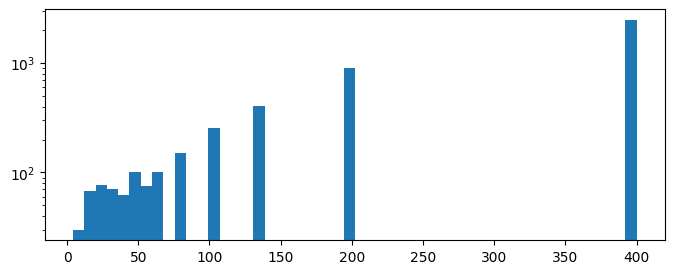

In [ ]:
import matplotlib.pyplot as plt

small_idf_values = idfsSmall.map(lambda s: s[1]).collect()
fig = plt.figure(figsize=(8,3))
plt.hist(small_idf_values, 50, log=True)
pass

### **(2f) Implement a TF-IDF function**


In [ ]:

def tfidf(tokens, idfs):
    """ Compute TF-IDF
    Args:
        tokens (list of str): input list of tokens from tokenize
        idfs (dictionary): record to IDF value
    Returns:
        dictionary: a dictionary of records to TF-IDF values
    """
    tfs = tf(tokens)
    tfIdfDict = dict(map(lambda kv: (kv[0], kv[1] * idfs[kv[0]]), tfs.items()))
    return tfIdfDict

recb000hkgj8k = amazonRecToToken.filter(lambda x: x[0] == 'b000hkgj8k').collect()[0][1]
idfsSmallWeights = idfsSmall.collectAsMap()
recb000hkgj8kWeights = tfidf(recb000hkgj8k, idfsSmallWeights)

rec_b000hkgj8k_weights = recb000hkgj8kWeights
print('Amazon record "b000hkgj8k" has tokens and weights:\n%s' % rec_b000hkgj8k_weights)

Amazon record "b000hkgj8k" has tokens and weights:
{'autocad': 33.33333333333333, '2007': 3.5087719298245617, 'courseware': 66.66666666666666, 'customizing': 16.666666666666664, 'interface': 3.0303030303030303, 'autodesk': 8.333333333333332, 'psg': 33.33333333333333}


In [ ]:
# TEST Implement a TF-IDF function (2f)
Test.assertEquals(rec_b000hkgj8k_weights,
                   {'autocad': 33.33333333333333, 'autodesk': 8.333333333333332,
                    'courseware': 66.66666666666666, 'psg': 33.33333333333333,
                    '2007': 3.5087719298245617, 'customizing': 16.666666666666664,
                    'interface': 3.0303030303030303}, 'incorrect rec_b000hkgj8k_weights')

1 test passed.


### **Part 3: ER as Text Similarity - Cosine Similarity**


### **(3a) Implement the components of a `cosineSimilarity` function**


In [ ]:

import math

def dotprod(a, b):
    """ Compute dot product
    Args:
        a (dictionary): first dictionary of record to value
        b (dictionary): second dictionary of record to value
    Returns:
        dotProd: result of the dot product with the two input dictionaries
    """
    return sum([value * b[key] for key, value in a.items() if key in b])

def norm(a):
    """ Compute square root of the dot product
    Args:
        a (dictionary): a dictionary of record to value
    Returns:
        norm: a dictionary of tokens to its TF values
    """
    return math.sqrt(dotprod(a, a))

def cossim(a, b):
    """ Compute cosine similarity
    Args:
        a (dictionary): first dictionary of record to value
        b (dictionary): second dictionary of record to value
    Returns:
        cossim: dot product of two dictionaries divided by the norm of the first dictionary and
                then by the norm of the second dictionary
    """
    return dotprod(a, b) / (norm(a) * norm(b))

testVec1 = {'foo': 2, 'bar': 3, 'baz': 5 }
testVec2 = {'foo': 1, 'bar': 0, 'baz': 20 }
dp = dotprod(testVec1, testVec2)
nm = norm(testVec1)
print(dp, nm)

102 6.164414002968976


In [ ]:
# TEST Implement the components of a cosineSimilarity function (3a)
Test.assertEquals(dp, 102, 'incorrect dp')
Test.assertTrue(abs(nm - 6.16441400297) < 0.0000001, 'incorrrect nm')

1 test passed.
1 test passed.


### **(3b) Implement a `cosineSimilarity` function**


In [ ]:
def cosineSimilarity(string1, string2, idfsDictionary):
    """ Compute cosine similarity between two strings
    Args:
        string1 (str): first string
        string2 (str): second string
        idfsDictionary (dictionary): a dictionary of IDF values
    Returns:
        cossim: cosine similarity value
    """
    w1 = tfidf(tokenize(string1), idfsDictionary)
    w2 = tfidf(tokenize(string2), idfsDictionary)
    return cossim(w1, w2)

cossimAdobe = cosineSimilarity('Adobe Photoshop',
                               'Adobe Illustrator',
                               idfsSmallWeights)

print(cossimAdobe)

0.05772433821630337


In [ ]:
# TEST Implement a cosineSimilarity function (3b)
Test.assertTrue(abs(cossimAdobe - 0.0577243382163) < 0.0000001, 'incorrect cossimAdobe')

1 test passed.


### **(3c) Perform Entity Resolution**


In [ ]:
crossSmall = (googleSmall
              .cartesian(amazonSmall)
              .cache())
idfs_small_weights = idfsSmallWeights

def computeSimilarity(record):
    """ Compute similarity on a combination record
    Args:
        record: a pair, (google record, amazon record)
    Returns:
        pair: a pair, (google URL, amazon ID, cosine similarity value)
    """
    googleRec = record[0]
    amazonRec = record[1]
    googleURL = googleRec[0]
    amazonID = amazonRec[0]
    googleValue = googleRec[1]
    amazonValue = amazonRec[1]
    cs = cosineSimilarity(googleValue, amazonValue, idfs_small_weights)
    return (googleURL, amazonID, cs)

similarities = (crossSmall
                .map(lambda record: computeSimilarity(record))
                .cache())

def similar(amazonID, googleURL):
    """ Return similarity value
    Args:
        amazonID: amazon ID
        googleURL: google URL
    Returns:
        similar: cosine similarity value
    """
    return (similarities
            .filter(lambda record: (record[0] == googleURL and record[1] == amazonID))
            .collect()[0][2])

similarityAmazonGoogle = similar('b000o24l3q', 'http://www.google.com/base/feeds/snippets/17242822440574356561')
print('Requested similarity is %s.' % similarityAmazonGoogle)

Requested similarity is 0.00030317194045132.


In [ ]:
# TEST Perform Entity Resolution (3c)
Test.assertTrue(abs(similarityAmazonGoogle - 0.000303171940451) < 0.0000001,
                'incorrect similarityAmazonGoogle')

1 test passed.


### **(3d) Perform Entity Resolution with Broadcast Variables**


In [ ]:

def computeSimilarityBroadcast(record):
    """ Compute similarity on a combination record, using Broadcast variable
    Args:
        record: a pair, (google record, amazon record)
    Returns:
        pair: a pair, (google URL, amazon ID, cosine similarity value)
    """
    googleRec = record[0]
    amazonRec = record[1]
    googleURL = googleRec[0]
    amazonID = amazonRec[0]
    googleValue = googleRec[1]
    amazonValue = amazonRec[1]
    cs = cosineSimilarity(googleValue, amazonValue, idfsSmallBroadcast.value)
    return (googleURL, amazonID, cs)

idfsSmallBroadcast = sc.broadcast(idfsSmallWeights)
similaritiesBroadcast = (crossSmall
                         .map(lambda record: computeSimilarityBroadcast(record))
                         .cache())

def similarBroadcast(amazonID, googleURL):
    """ Return similarity value, computed using Broadcast variable
    Args:
        amazonID: amazon ID
        googleURL: google URL
    Returns:
        similar: cosine similarity value
    """
    return (similaritiesBroadcast
            .filter(lambda record: (record[0] == googleURL and record[1] == amazonID))
            .collect()[0][2])

similarityAmazonGoogleBroadcast = similarBroadcast('b000o24l3q', 'http://www.google.com/base/feeds/snippets/17242822440574356561')
print('Requested similarity is %s.' % similarityAmazonGoogleBroadcast)

Requested similarity is 0.00030317194045132.


In [ ]:
# TEST Perform Entity Resolution with Broadcast Variables (3d)
from pyspark import Broadcast
Test.assertTrue(isinstance(idfsSmallBroadcast, Broadcast), 'incorrect idfsSmallBroadcast')
Test.assertEquals(len(idfsSmallBroadcast.value), 4772, 'incorrect idfsSmallBroadcast value')
Test.assertTrue(abs(similarityAmazonGoogleBroadcast - 0.000303171940451) < 0.0000001,
                'incorrect similarityAmazonGoogle')

1 test passed.
1 test passed.
1 test passed.


### **(3e) Perform a Gold Standard evaluation**
#### First, we'll load the "gold standard" data and use it to answer several questions. We read and parse the Gold Standard data, where the format of each line is "Amazon Product ID","Google URL". The resulting RDD has elements of the form ("AmazonID GoogleURL", 'gold')

In [ ]:
GOLDFILE_PATTERN = '^(.+),(.+)'

# Parse each line of a data file useing the specified regular expression pattern
def parse_goldfile_line(goldfile_line):
    """ Parse a line from the 'golden standard' data file
    Args:
        goldfile_line: a line of data
    Returns:
        pair: ((key, 'gold', 1 if successful or else 0))
    """
    match = re.search(GOLDFILE_PATTERN, goldfile_line)
    if match is None:
        print('Invalid goldfile line: %s' % goldfile_line)
        return (goldfile_line, -1)
    elif match.group(1) == '"idAmazon"':
        print('Header datafile line: %s' % goldfile_line)
        return (goldfile_line, 0)
    else:
        key = '%s %s' % (removeQuotes(match.group(1)), removeQuotes(match.group(2)))
        return ((key, 'gold'), 1)

goldfile = GOLD_STANDARD_PATH
gsRaw = (sc
         .textFile(goldfile)
         .map(parse_goldfile_line)
         .cache())

gsFailed = (gsRaw
            .filter(lambda s: s[1] == -1)
            .map(lambda s: s[0]))
for line in gsFailed.take(10):
    print('Invalid goldfile line: %s' % line)

goldStandard = (gsRaw
                .filter(lambda s: s[1] == 1)
                .map(lambda s: s[0])
                .cache())

print('Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (gsRaw.count(),
                                                                                 goldStandard.count(),
                                                                                 gsFailed.count()))
assert (gsFailed.count() == 0)
assert (gsRaw.count() == (goldStandard.count() + 1))

Read 1301 lines, successfully parsed 1300 lines, failed to parse 0 lines



* #### How many true duplicate pairs are there in the small datasets?
* #### What is the average similarity score for true duplicates?
* #### What about for non-duplicates?


In [ ]:

sims = similaritiesBroadcast.map(lambda googleURL_amazonID_cs: ("{0} {1}".format(googleURL_amazonID_cs[1], googleURL_amazonID_cs[0]), googleURL_amazonID_cs[2]))

trueDupsRDD = (sims
               .join(goldStandard))
trueDupsCount = trueDupsRDD.count()
avgSimDups = trueDupsRDD.map(lambda key_value: key_value[1][0]).reduce(lambda a, b: a + b) / float(trueDupsCount)

nonDupsRDD = (sims
              .leftOuterJoin(goldStandard)
              .filter(lambda key_value: key_value[1][1] is None)
              .map(lambda key_value: key_value[1][0]))
avgSimNon = nonDupsRDD.reduce(lambda a, b: a + b) / float(nonDupsRDD.count())

print('There are %s true duplicates.' % trueDupsCount)
print('The average similarity of true duplicates is %s.' % avgSimDups)
print('And for non duplicates, it is %s.' % avgSimNon)

There are 146 true duplicates.
The average similarity of true duplicates is 0.26433257343519145.
And for non duplicates, it is 0.0012347630465555245.


In [ ]:
# TEST Perform a Gold Standard evaluation (3e)
Test.assertEquals(trueDupsCount, 146, 'incorrect trueDupsCount')
Test.assertTrue(abs(avgSimDups - 0.264332573435) < 0.0000001, 'incorrect avgSimDups')
Test.assertTrue(abs(avgSimNon - 0.00123476304656) < 0.0000001, 'incorrect avgSimNon')

1 test passed.
1 test passed.
1 test passed.
